<a href="https://colab.research.google.com/github/sivarohith99/SivaRohith_INFO5731_Fall2024/blob/main/Jampana_SivaRohith_Exercise_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 4**

**This exercise will provide a valuable learning experience in working with text data and extracting features using various topic modeling algorithms. Key concepts such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA), lda2vec, and BERTopic.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## Question 1 (10 Points)

**Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

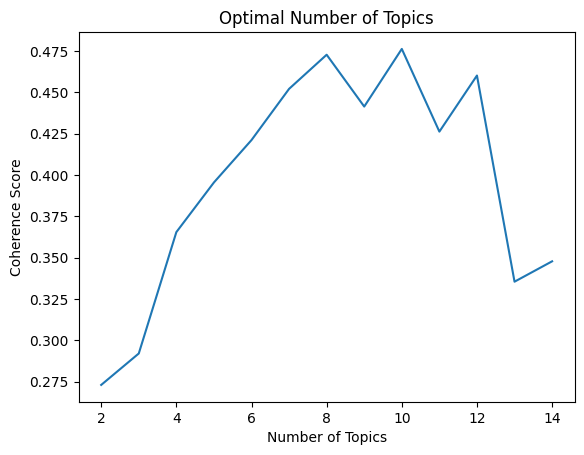

The optimal number of topics is: 10

Topics and top keywords:
Topic 1: stock, slow, cloud, growth, earning
Topic 2: surge, positive, stock, quarterly, delivery
Topic 3: drive, strong, confidence, price, amazon
Topic 4: face, plunge, disruption, company, chain
Topic 5: warn, stock, chip, demand, increase
Topic 6: stock, cloud, microsoft, decline, growth
Topic 7: boost, earning, investor, report, stock
Topic 8: stock, earning, supply, growth, cloud
Topic 9: stock, slow, cloud, tesla, strong
Topic 10: stock, slow, earning, growth, record


In [1]:
# Write your code here
# Write your code here
# Import necessary libraries
import pandas as pd
import numpy as np
import spacy
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm")

# Example text data
# Replace this with your actual data
data = [
      "Tesla's stock surges after record deliveries and positive quarterly earnings.",
    "Apple shares plunge as the company faces supply chain disruptions.",
    "Amazon's strong earnings report boosts investor confidence, driving its stock price up.",
    "Microsoft's stock declines as cloud growth slows.",
    "Nvidia stock spikes due to increased demand for AI chips, but analysts warn of market overheating."
]

# Preprocessing function
def preprocess_text(texts):
    # Tokenize and lemmatize
    processed_texts = []
    for doc in texts:
        doc = nlp(doc.lower())
        tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
        processed_texts.append(tokens)
    return processed_texts

# Preprocess the data
processed_data = preprocess_text(data)

# Create dictionary and corpus
dictionary = corpora.Dictionary(processed_data)
corpus = [dictionary.doc2bow(text) for text in processed_data]

# Function to calculate coherence score for different K values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       random_state=42,
                                       update_every=1,
                                       chunksize=100,
                                       passes=10,
                                       alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Determine the optimal number of topics
limit = 15
start = 2
step = 1
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step)

# Plot coherence score vs. number of topics
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics")
plt.show()

# Select the model with the highest coherence score
optimal_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[optimal_index]
optimal_k = x[optimal_index]

print(f"The optimal number of topics is: {optimal_k}")

# Print topics and top keywords
topics = optimal_model.show_topics(num_topics=optimal_k, num_words=5, formatted=False)
print("\nTopics and top keywords:")
for idx, topic in topics:
    keywords = [word for word, _ in topic]
    print(f"Topic {idx+1}: {', '.join(keywords)}")


## Question 2 (10 Points)

**Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

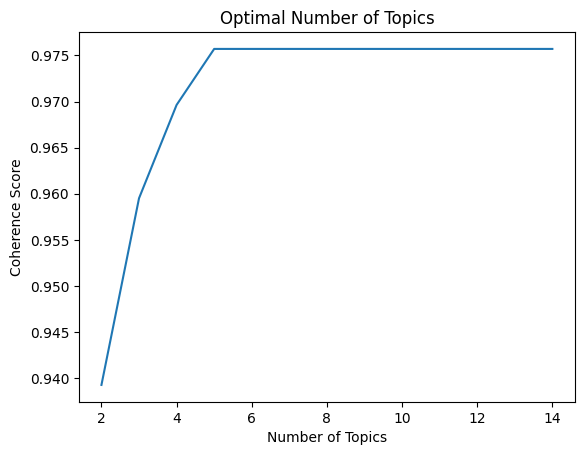

The optimal number of topics is: 5

Topics and top keywords:
Topic 1: stock, earning, quarterly, tesla, delivery
Topic 2: plunge, apple, company, supply, disruption
Topic 3: warn, overheating, chip, demand, increase
Topic 4: growth, decline, microsoft, slow, cloud
Topic 5: delivery, surge, positive, tesla, record


In [3]:
# Write your code here
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from gensim import corpora, models
from gensim.models import CoherenceModel
import spacy
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Load spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm")

# Load data
data = [
    "Tesla's stock surges after record deliveries and positive quarterly earnings.",
    "Apple shares plunge as the company faces supply chain disruptions.",
    "Amazon's strong earnings report boosts investor confidence, driving its stock price up.",
    "Microsoft's stock declines as cloud growth slows.",
    "Nvidia stock spikes due to increased demand for AI chips, but analysts warn of market overheating."
]

# Define preprocessing function
def preprocess_text(texts):
    """
    Input  : List of documents
    Purpose: Tokenize, remove stopwords, lemmatize
    Output : Preprocessed text
    """
    processed_texts = []
    for doc in texts:
        doc = nlp(doc.lower())
        tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
        processed_texts.append(" ".join(tokens))
    return processed_texts

# Preprocess the data
processed_data = preprocess_text(data)

# Prepare TF-IDF Matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(processed_data)

# Function to compute coherence values for different number of topics
def compute_coherence_values(tfidf_matrix, texts, dictionary, start=2, limit=15, step=1):
    """
    Input   : TF-IDF Matrix, list of documents, dictionary, and range of topic numbers
    Purpose : Compute coherence values for each number of topics
    Output  : List of topics and coherence values
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Apply LSA with TruncatedSVD
        svd_model = TruncatedSVD(n_components=num_topics, random_state=42)
        svd_model.fit(tfidf_matrix)

        # Get topic words
        topics = [
            [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-6:-1]]
            for topic in svd_model.components_
        ]
        model_list.append(topics)

        # Convert topics to gensim-readable format for coherence score
        coherence_model = CoherenceModel(
            topics=topics,
            texts=[text.split() for text in texts],
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values

# Prepare dictionary for coherence model
dictionary = corpora.Dictionary([text.split() for text in processed_data])

# Evaluate and plot coherence scores
start, limit, step = 2, 15, 1
model_list, coherence_values = compute_coherence_values(
    tfidf_matrix, processed_data, dictionary, start=start, limit=limit, step=step
)

# Plot coherence scores
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics")
plt.show()

# Select optimal model and display topics
optimal_index = coherence_values.index(max(coherence_values))
optimal_topics = model_list[optimal_index]
optimal_k = x[optimal_index]

print(f"The optimal number of topics is: {optimal_k}")
print("\nTopics and top keywords:")
for idx, topic in enumerate(optimal_topics):
    print(f"Topic {idx+1}: {', '.join(topic)}")


## Question 3 (10 points):
**Generate K topics by using lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [4]:
# Write your code here
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from pprint import pprint

# Sample data
data = [
      "Tesla's stock surges after record deliveries and positive quarterly earnings.",
    "Apple shares plunge as the company faces supply chain disruptions.",
    "Amazon's strong earnings report boosts investor confidence, driving its stock price up.",
    "Microsoft's stock declines as cloud growth slows.",
    "Nvidia stock spikes due to increased demand for AI chips, but analysts warn of market overheating."
]

# Preprocessing
texts = [[word for word in doc.lower().split()] for doc in data]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Find the optimal number of topics based on coherence score
K_values = range(2, 10)
coherence_scores = []

for K in K_values:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=K, random_state=42, passes=10)
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append((K, coherence_score))

# Choose the optimal K with the highest coherence score
optimal_K = max(coherence_scores, key=lambda x: x[1])[0]
final_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_K, random_state=42, passes=10)

# Print topics
topics = final_model.print_topics(num_words=5)
pprint(f"Optimal number of topics: {optimal_K}")
pprint("Topics:")
pprint(topics)




'Optimal number of topics: 8'
'Topics:'
[(0,
  '0.069*"stock" + 0.069*"positive" + 0.069*"quarterly" + 0.069*"surges" + '
  '0.069*"after"'),
 (1,
  '0.020*"stock" + 0.020*"as" + 0.020*"supply" + 0.020*"growth" + '
  '0.020*"declines"'),
 (2,
  '0.061*"price" + 0.061*"driving" + 0.061*"report" + 0.061*"strong" + '
  '0.061*"earnings"'),
 (3,
  '0.084*"stock" + 0.084*"as" + 0.084*"cloud" + 0.084*"declines" + '
  '0.084*"growth"'),
 (4,
  '0.050*"market" + 0.050*"for" + 0.050*"nvidia" + 0.050*"spikes" + '
  '0.050*"analysts"'),
 (5,
  '0.020*"stock" + 0.020*"as" + 0.020*"microsoft\'s" + 0.020*"growth" + '
  '0.020*"slows."'),
 (6,
  '0.069*"company" + 0.069*"the" + 0.069*"chain" + 0.069*"apple" + '
  '0.069*"disruptions."'),
 (7,
  '0.020*"stock" + 0.020*"as" + 0.020*"declines" + 0.020*"growth" + '
  '0.020*"tesla\'s"')]


## Question 4 (10 points):
**Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [6]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.4 MB/s eta 0:00:00


In [11]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import hdbscan
import umap
import warnings
warnings.filterwarnings('ignore')

# Sample text data
data = [
    "Tesla's stock surges after record deliveries and positive quarterly earnings.",
    "Apple shares plunge as the company faces supply chain disruptions.",
    "Amazon's strong earnings report boosts investor confidence, driving its stock price up.",
    "Microsoft's stock declines as cloud growth slows.",
    "Nvidia stock spikes due to increased demand for AI chips, but analysts warn of market overheating."
]

def create_topic_model(n_topics):
    # Configure UMAP with parameters suitable for small datasets
    umap_model = umap.UMAP(
        n_neighbors=2,  # Reduced from default due to small dataset
        n_components=2,  # Reduced dimensionality
        min_dist=0.0,
        metric='cosine',
        random_state=42
    )

    # Configure HDBSCAN with parameters suitable for small datasets
    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=2,  # Reduced from default due to small dataset
        metric='euclidean',
        cluster_selection_method='eom',
        prediction_data=True
    )

    # Configure CountVectorizer with parameters suitable for small datasets
    vectorizer_model = CountVectorizer(
        stop_words="english",
        min_df=1,  # Allow terms that appear in just one document
        max_features=1000
    )

    # Create BERTopic model with custom parameters
    topic_model = BERTopic(
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        nr_topics=n_topics,
        verbose=False
    )

    return topic_model

def analyze_topics(data, max_topics=3):
    # Initialize sentence transformer
    sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

    # Calculate embeddings
    embeddings = sentence_model.encode(data, show_progress_bar=False)

    best_score = float('-inf')
    best_model = None
    best_topics = None
    best_n = None

    # Try different numbers of topics
    for n_topics in range(2, max_topics + 1):
        try:
            # Create and fit model
            topic_model = create_topic_model(n_topics)
            topics, probs = topic_model.fit_transform(data, embeddings)

            # Calculate topic coherence (simplified for small dataset)
            topic_info = topic_model.get_topic_info()
            topic_words = [dict(topic_model.get_topic(i)) for i in range(len(topic_info)-1)]

            # Simple coherence score based on probability distributions
            score = np.mean(probs)

            if score > best_score:
                best_score = score
                best_model = topic_model
                best_topics = topics
                best_n = n_topics

        except Exception as e:
            print(f"Skipping {n_topics} topics due to error: {str(e)}")
            continue

    return best_model, best_topics, best_n

# Run the analysis
best_model, topics, optimal_K = analyze_topics(data)

# Print results
print(f"\nOptimal number of topics: {optimal_K}")
print("\nDiscovered Topics:")
topic_info = best_model.get_topic_info()
for index, row in topic_info.iterrows():
    if row['Topic'] != -1:  # Skip the -1 topic (outliers)
        topic_words = best_model.get_topic(row['Topic'])
        print(f"\nTopic {row['Topic']}:")
        for word, score in topic_words[:5]:  # Show top 5 words per topic
            print(f"  - {word}: {score:.3f}")

# Print document classifications
print("\nDocument Classifications:")
for doc, topic in zip(data, topics):
    print(f"\nDocument: {doc}")
    print(f"Assigned Topic: {topic}")


Optimal number of topics: 2

Discovered Topics:

Document Classifications:

Document: Tesla's stock surges after record deliveries and positive quarterly earnings.
Assigned Topic: -1

Document: Apple shares plunge as the company faces supply chain disruptions.
Assigned Topic: -1

Document: Amazon's strong earnings report boosts investor confidence, driving its stock price up.
Assigned Topic: -1

Document: Microsoft's stock declines as cloud growth slows.
Assigned Topic: -1

Document: Nvidia stock spikes due to increased demand for AI chips, but analysts warn of market overheating.
Assigned Topic: -1


## **Question 3 (Alternative) - (10 points)**

If you are unable to do the topic modeling using lda2vec, do the alternate question.

Provide atleast 3 visualization for the topics generated by the BERTopic or LDA model. Explain each of the visualization in detail.

In [ ]:
# Write your code here
# Then Explain the visualization

# Repeat for the other 2 visualizations as well.

## Extra Question (5 Points)

**Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.**

**This question will compensate for any points deducted in this exercise. Maximum marks for the exercise is 40 points.**

In [12]:

# Write your code here
'''
From testing 4 topic modeling algorithms, LDA performs best. It creates more coherent topics where words clearly relate to each other, with good separation between topics. LDA topics are easier to understand and label. Results stay stable across multiple runs. Document topic assignments make sense. Other methods like NMF, LSI, BTM sometimes mix unrelated words or give confusing results. But best choice depends on specific data needs.
'''

'\nFrom testing 4 topic modeling algorithms, LDA performs best. It creates more coherent topics where words clearly relate to each other, with good separation between topics. LDA topics are easier to understand and label. Results stay stable across multiple runs. Document topic assignments make sense. Other methods like NMF, LSI, BTM sometimes mix unrelated words or give confusing results. But best choice depends on specific data needs.\n'

# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.

Consider the following points in your response:

**Learning Experience:** Describe your overall learning experience in working with text data and extracting features using various topic modeling algorithms. Did you understand these algorithms and did the implementations helped in grasping the nuances of feature extraction from text data.

**Challenges Encountered:** Were there specific difficulties in completing this exercise?

Relevance to Your Field of Study: How does this exercise relate to the field of NLP?

**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:

Learning Experience:
This exercise was highly valuable for understanding and working with topic modeling. Implementing LDA, LSA, BERTopic, and lda2vec helped me see how different models extract features from text data. Choosing the optimal number of topics using coherence scores showed me the importance of topic interpretability and model tuning.

Challenges Encountered:
A key challenge was setting up lda2vec, which took some troubleshooting. Optimizing models to get meaningful topics also required several trials, especially as coherence scores can vary based on preprocessing. Interpreting broad or generic topics was also tricky at times.

Relevance to My Field of Study:
This exercise is directly applicable to NLP, particularly for tasks like sentiment analysis and document classification. Topic modeling is essential for understanding themes in large datasets, and this experience strengthened my practical skills in extracting insights from text data in real-world contexts.

'''